In [ ]:
import glob
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#sklearn
from sklearn.cluster import KMeans
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import SGD
from keras import utils
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
# from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Import and Cleaning

In [ ]:
# data = pd.read_csv("/content/drive/MyDrive/BIA-667/tweets_with_labels.csv")
# data = pd.read_csv("/content/drive/MyDrive/datasets/tweets_with_labels.csv") # gmail_acc
data = pd.read_csv("/content/drive/MyDrive/datasets/tweets_with_labels.csv") #stevens_acc
data["text"] = data[" text"]
data = data.drop(["tweet_id", "user_id", "tweet_timestamp", " text"], axis=1) # drop the columns that we do not care about
print(f"Total tweets captured from twitter API: {len(data)}")

# Tweet lenghts that <3 and >230 chars might be a result of error in tweet collection and preprocessing
cnt = 0
short_ids = []
long_ids = []
for idx, tweet in enumerate(data["text"]):
  if len(tweet) < 4:
    short_ids.append(idx)
    cnt += 1
  elif len(tweet) > 280:
    long_ids.append(idx)
    cnt += 1

ids_to_drop = short_ids + long_ids

print(f"Dropping {len(short_ids)} less than 4 chars, and {len(long_ids)} as they are over 280 chars, total of {len(ids_to_drop)}")
data = data.drop(index=ids_to_drop)
print(f"Tweets available {len(data)}")

Total tweets captured from twitter API: 928881
Dropping 411 less than 4 chars, and 28327 as they are over 280 chars, total of 28738
Tweets available 900143


In [ ]:
# Reduce the datasize to 500,000 to experiment
data = data[:200000]

In [ ]:
data.head()

,keyword,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,text
0,wuhan,0.384,0.572,0.358,0.195,0.453,negative,fear,The Wuhan Virus: How to Stay Safe
1,wuhan,0.460,0.359,0.435,0.276,0.406,negative,anger,@Jimmyjude13 Well I mean...
2,wuhan,0.443,0.459,0.410,0.278,0.369,negative,fear,US to expand virus screening at 20 airports fo...
3,wuhan,0.403,0.520,0.448,0.224,0.449,negative,fear,@DrOz: Reports surrounding coronavirus have be...
4,wuhan,0.503,0.465,0.378,0.338,0.409,neutral or mixed,no specific emotion,Wuhan in lock down: I speak with Wayne Dupleis...


In [ ]:
counts = {}
lenghts = []
for tw in data["text"]:
  lens = len(tw)
  lenghts.append(lens)
  if lens in counts:
    counts[lens] = counts[lens] + 1
  else:
    counts[lens] = 1

In [ ]:
pdc = pd.DataFrame(lenghts)

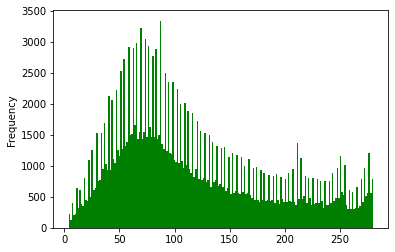

In [ ]:
pdc[0].plot.hist(bins=200, color='g')

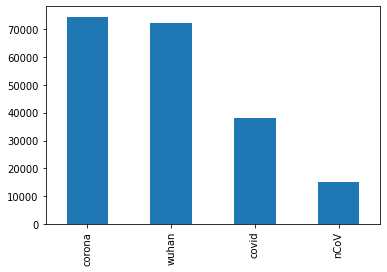

In [ ]:
data["keyword"].value_counts().plot(kind="bar")


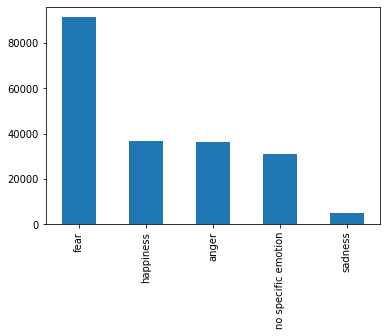

In [ ]:
data["emotion"].value_counts().plot(kind="bar")

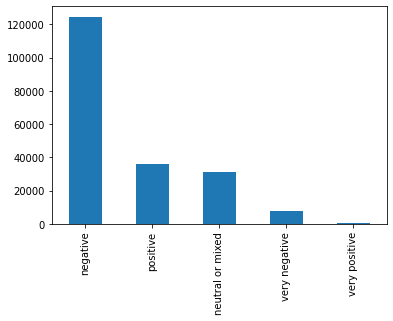

In [ ]:
data["sentiment"].value_counts().plot(kind="bar")

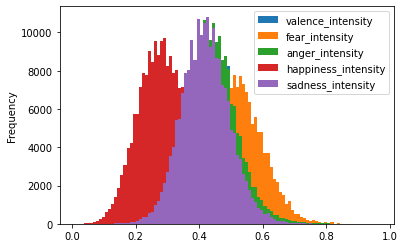

In [ ]:
data.plot.hist(bins=100)

In [ ]:
# tweet_text = data.text
# # only consider the top max_features 10000 ordered by term frequency across the corpus.
# # min_df - try this to improve efficieny
# vectorizer = TfidfVectorizer(stop_words="english", lowercase=True, analyzer = 'word', max_features=10000)
# X = vectorizer.fit_transform(tweet_text)

In [ ]:
data.drop(['keyword','valence_intensity','fear_intensity','anger_intensity','happiness_intensity', 'sadness_intensity', 'sentiment'], axis=1, inplace=True)

In [ ]:
data.emotion = data.emotion.replace({'fear': 0, 'anger': 1, 'no specific emotion': 2, 'happiness': 3,'sadness': 4 })
data.emotion.unique()

array([0, 1, 2, 3, 4])

In [ ]:
english_stopwords = stopwords.words('english')
#base of english stopwords
stemmer = SnowballStemmer('english')
#stemming algorithm
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
#regex for mentions and links in tweets

In [ ]:
def preprocess(content, stem=False):
  english_stopwords = stopwords.words('english')
  #base of english stopwords
  stemmer = SnowballStemmer('english')
  #stemming algorithm
  regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
  #regex for mentions and links in tweets
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)


In [ ]:
data.text = data.text.apply(lambda x: preprocess(x))

In [ ]:
data.head()

,emotion,text
0,0,wuhan virus stay safe
1,1,well mean
2,0,us expand virus screen 20 airport visitor chin...
3,0,report surround coronavirus chang rapid need k...
4,2,wuhan lock speak wayn dupleiss canadian citize...


## Text Train Split

In [ ]:
train, test = train_test_split(data, test_size=0.3, random_state=44)

In [ ]:
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (140000, 2)
Test dataset shape: (60000, 2)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = 280

In [ ]:
sequences_train = tokenizer.texts_to_sequences(train.text) 
sequences_test = tokenizer.texts_to_sequences(test.text) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.emotion.values
y_test = test.emotion.values

In [ ]:
def vectorizer(text):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train.text)  
  vocab_size = len(tokenizer.word_index) + 1 
  max_length = 280
  sequence = tokenizer.texts_to_sequences(text) 
  text_vector = pad_sequences(sequence, maxlen=max_length, padding='post')
  return text_vector


In [ ]:
def to_one_hot(labels, dimension=5):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1. 
    return results

In [ ]:
y_train  = to_one_hot(y_train)
y_test  = to_one_hot(y_test)

def plot_hostory(history):
  #History for accuracy
  plt.figure(figsize=(5,5))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
  plt.show()

  plt.figure(figsize=(5,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train loss', 'Test loss'], loc='upper right')
  plt.show()

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100
# glove_file = open('/content/drive/MyDrive/BIA-667/glove.6B.100d.txt')
glove_file = open('/content/drive/MyDrive/datasets/glove.6B.100d.txt',  errors = 'ignore', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

**Bidirectional LSTM**

In [ ]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid'),
    ])

model.summary()
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          5637100   
                                                                 
 bidirectional (Bidirectiona  (None, 280, 128)         84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 280, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
tb = TensorBoard('logs')

In [ ]:
history = LSTM.fit(X_train, y_train, batch_size = 1000, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stop, reduce_LR, checkpoint, tb], verbose=2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.08061, saving model to weights.h5
140/140 - 38s - loss: 1.1721 - accuracy: 0.5283 - val_loss: 1.0806 - val_accuracy: 0.5670 - lr: 0.0010 - 38s/epoch - 274ms/step
Epoch 2/50

Epoch 00002: val_loss improved from 1.08061 to 1.03426, saving model to weights.h5
140/140 - 31s - loss: 1.0544 - accuracy: 0.5780 - val_loss: 1.0343 - val_accuracy: 0.5817 - lr: 0.0010 - 31s/epoch - 218ms/step
Epoch 3/50

Epoch 00003: val_loss improved from 1.03426 to 1.02318, saving model to weights.h5
140/140 - 30s - loss: 1.0173 - accuracy: 0.5918 - val_loss: 1.0232 - val_accuracy: 0.5867 - lr: 0.0010 - 30s/epoch - 213ms/step
Epoch 4/50

Epoch 00004: val_loss improved from 1.02318 to 0.99688, saving model to weights.h5
140/140 - 31s - loss: 0.9942 - accuracy: 0.6012 - val_loss: 0.9969 - val_accuracy: 0.5972 - lr: 0.0010 - 31s/epoch - 219ms/step
Epoch 5/50

Epoch 00005: val_loss improved from 0.99688 to 0.98126, saving model to weights.h5
140/140 - 30s - l

In [ ]:
model.save("/content/drive/MyDrive/bidirectional_history") 

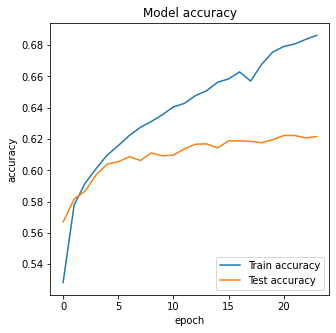

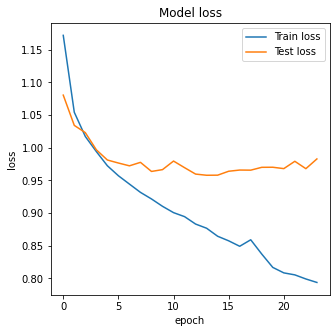

In [ ]:
plot_hostory(history)

**CNN**

In [ ]:
CNN = Sequential([
        embedding_layer,
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid')
    ])
CNN.summary()
CNN.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          5637100   
                                                                 
 conv1d_9 (Conv1D)           (None, 280, 32)           9632      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 140, 32)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 140, 64)           6208      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 70, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 70, 128)          

In [ ]:
history = CNN.fit(X_train, y_train, batch_size = 1000, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stop, reduce_LR, checkpoint, tb], verbose=2)

Epoch 1/50

Epoch 00001: val_loss did not improve from 0.98727
140/140 - 4s - loss: 1.1809 - accuracy: 0.5166 - val_loss: 1.0974 - val_accuracy: 0.5544 - lr: 0.0010 - 4s/epoch - 28ms/step
Epoch 2/50

Epoch 00002: val_loss did not improve from 0.98727
140/140 - 3s - loss: 1.0633 - accuracy: 0.5722 - val_loss: 1.0553 - val_accuracy: 0.5740 - lr: 0.0010 - 3s/epoch - 21ms/step
Epoch 3/50

Epoch 00003: val_loss did not improve from 0.98727
140/140 - 3s - loss: 1.0272 - accuracy: 0.5876 - val_loss: 1.0406 - val_accuracy: 0.5789 - lr: 0.0010 - 3s/epoch - 21ms/step
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.98727
140/140 - 3s - loss: 1.0009 - accuracy: 0.5986 - val_loss: 1.0408 - val_accuracy: 0.5812 - lr: 0.0010 - 3s/epoch - 21ms/step
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.98727
140/140 - 3s - loss: 0.9840 - accuracy: 0.6071 - val_loss: 1.0233 - val_accuracy: 0.5899 - lr: 0.0010 - 3s/epoch - 21ms/step
Epoch 6/50

Epoch 00006: val_loss did not improve from 0.987

In [ ]:
CNN.save("/content/drive/MyDrive/CNN_history") 

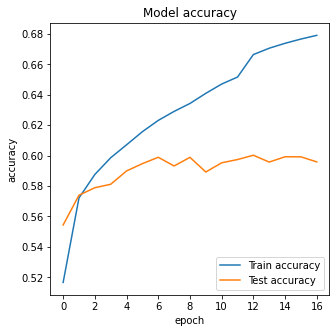

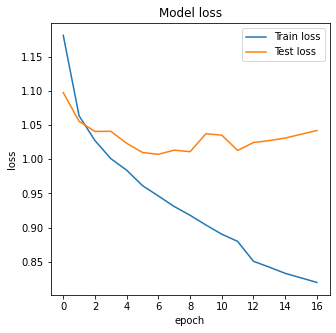

In [ ]:
plot_hostory(history)

**Hybrid (CNN + LSTM)**

In [ ]:
classifier = Sequential([
        embedding_layer,
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(64)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid')
    ])

classifier.summary()
classifier.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 280, 100)          5637100   
                                                                 
 conv1d_4 (Conv1D)           (None, 280, 32)           9632      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 140, 32)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 140, 64)           6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 70, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_8 (Bidirectio  (None, 70, 128)         

In [ ]:
history = classifier.fit(X_train, y_train, batch_size = 1000, epochs=50, validation_data=(X_test, y_test),callbacks=[early_stop, reduce_LR, checkpoint, tb], verbose=2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.10097, saving model to weights.h5
140/140 - 29s - loss: 1.2100 - accuracy: 0.5101 - val_loss: 1.1010 - val_accuracy: 0.5562 - lr: 0.0010 - 29s/epoch - 210ms/step
Epoch 2/50

Epoch 00002: val_loss improved from 1.10097 to 1.05722, saving model to weights.h5
140/140 - 15s - loss: 1.0812 - accuracy: 0.5663 - val_loss: 1.0572 - val_accuracy: 0.5718 - lr: 0.0010 - 15s/epoch - 108ms/step
Epoch 3/50

Epoch 00003: val_loss improved from 1.05722 to 1.03859, saving model to weights.h5
140/140 - 15s - loss: 1.0444 - accuracy: 0.5799 - val_loss: 1.0386 - val_accuracy: 0.5821 - lr: 0.0010 - 15s/epoch - 107ms/step
Epoch 4/50

Epoch 00004: val_loss improved from 1.03859 to 1.02785, saving model to weights.h5
140/140 - 15s - loss: 1.0224 - accuracy: 0.5887 - val_loss: 1.0278 - val_accuracy: 0.5867 - lr: 0.0010 - 15s/epoch - 108ms/step
Epoch 5/50

Epoch 00005: val_loss improved from 1.02785 to 1.01219, saving model to weights.h5
140/140 - 15s - l

In [ ]:
classifier.save("/content/drive/MyDrive/Hybrid_history") 

**AutoEncoder**

In [ ]:
encoding_dim = 200
input_df = Input(shape=(280,))

unsupervised_model = embedding_layer
unsupervised_model = Dense(encoding_dim, activation='relu')(input_df)
unsupervised_model = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(unsupervised_model)
unsupervised_model = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(unsupervised_model)
unsupervised_model = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(unsupervised_model)

encoded = Dense(10, activation='relu', kernel_initializer = 'glorot_uniform')(unsupervised_model)

unsupervised_model = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
unsupervised_model = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(unsupervised_model)

decoded = Dense(280, kernel_initializer = 'glorot_uniform')(unsupervised_model)

autoencoder = Model(input_df, decoded)

encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

In [ ]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 280)]             0         
                                                                 
 dense_55 (Dense)            (None, 200)               56200     
                                                                 
 dense_56 (Dense)            (None, 500)               100500    
                                                                 
 dense_57 (Dense)            (None, 500)               250500    
                                                                 
 dense_58 (Dense)            (None, 2000)              1002000   
                                                                 
 dense_59 (Dense)            (None, 10)                20010     
                                                                 
 dense_60 (Dense)            (None, 2000)              220

In [ ]:
reduce_LR = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

In [ ]:
history = autoencoder.fit(X_train, X_train, batch_size = 1028, epochs = 1000, callbacks=[reduce_LR, tb], verbose = 1)

Epoch 1/1000
137/137 [==============================] - 1s 7ms/step - loss: 754463.6250 - lr: 0.0010
Epoch 2/1000
137/137 [==============================] - 1s 6ms/step - loss: 379415.9375 - lr: 0.0010
Epoch 3/1000
137/137 [==============================] - 1s 6ms/step - loss: 316030.3125 - lr: 0.0010
Epoch 4/1000
137/137 [==============================] - 1s 6ms/step - loss: 286383.8750 - lr: 0.0010
Epoch 5/1000
137/137 [==============================] - 1s 6ms/step - loss: 265894.6562 - lr: 0.0010
Epoch 6/1000
137/137 [==============================] - 1s 6ms/step - loss: 246272.4688 - lr: 0.0010
Epoch 7/1000
137/137 [==============================] - 1s 6ms/step - loss: 235916.3750 - lr: 0.0010
Epoch 8/1000
137/137 [==============================] - 1s 6ms/step - loss: 223656.9531 - lr: 0.0010
Epoch 9/1000
137/137 [==============================] - 1s 6ms/step - loss: 211622.3281 - lr: 0.0010
Epoch 10/1000
137/137 [==============================] - 1s 6ms/step - loss: 205234.7344 - 

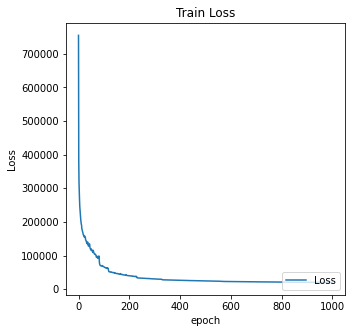

In [ ]:
  plt.figure(figsize=(5,5))
  plt.plot(history.history['loss'])
  plt.title('Train Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['Loss'], loc='lower right')
  plt.show()

In [ ]:
autoencoder.save_weights('autoencoder.h5')
autoencoder.save("/content/drive/MyDrive/autoencoder_history") 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/autoencoder_history/assets


In [ ]:
pred = encoder.predict(X_train)

In [ ]:
pred.shape

(140000, 10)

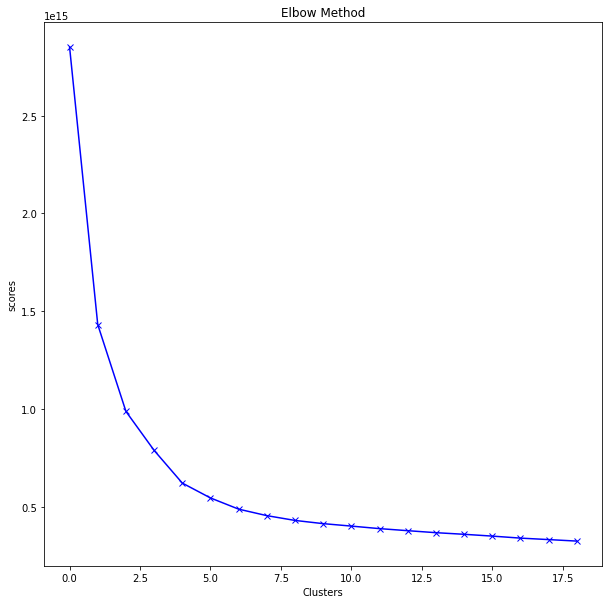

In [ ]:
wcss = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters= i)
  kmeans.fit(pred)
  wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,10))
plt.plot(wcss, 'bx-')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

In [ ]:
kmeans = KMeans(6)
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(X_train)

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=0)

visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)

visualizer.fit(pred)    
visualizer.poof() 

In [ ]:
df_cluster = pd.concat([data, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster.head()

,emotion,text,cluster
0,0.0,wuhan virus stay safe,0.0
1,1.0,well mean,0.0
2,0.0,us expand virus screen 20 airport visitor chin...,0.0
3,0.0,report surround coronavirus chang rapid need k...,0.0
4,2.0,wuhan lock speak wayn dupleiss canadian citize...,0.0


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-3882.054443,-8371.849609
1,-34149.867188,-1015.696716
2,-26509.451172,-4875.035645
3,-24187.763672,4970.405273
4,-34616.410156,45.714355


In [ ]:
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-3882.054443,-8371.849609,0
1,-34149.867188,-1015.696716,0
2,-26509.451172,-4875.035645,0
3,-24187.763672,4970.405273,0
4,-34616.410156,45.714355,0


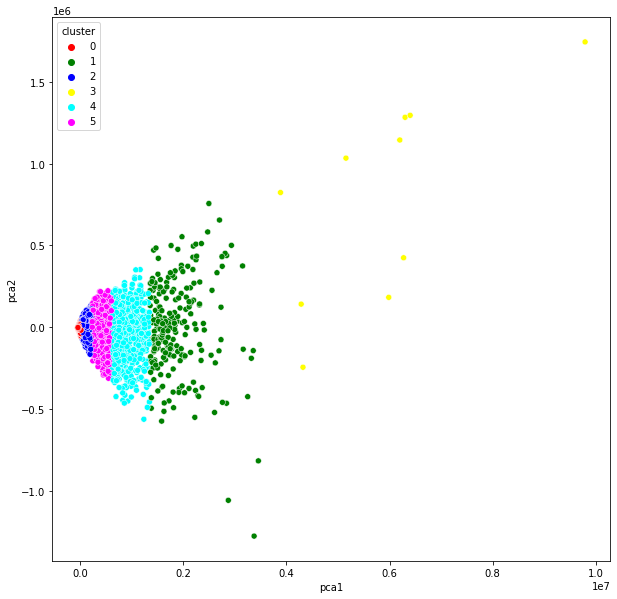

In [ ]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','yellow','cyan','magenta'])
plt.show()

In [ ]:
# path = "/content/drive/MyDrive/datasets/policy_tweets"
model.save("/content/drive/MyDrive/bidirectional_history") 

In [ ]:
# import tensorflow
# model = tensorflow.keras.models.load_model('/content/drive/MyDrive/bidirectional_history')

In [ ]:
# file_list = glob.glob(path+"/*.csv") 
pd1 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Mask_Mandate.csv", header=None)
pd2 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Mass_Gathering.csv", header=None)
pd3 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Lockdown.csv", header=None)
pd4 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Health_Testing.csv", header=None)
pd5 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Vaccine.csv", header=None)
pd6 = pd.read_csv("/content/drive/MyDrive/datasets/policy_tweets/Business_Restriction.csv", header=None)

df1 = pd1.append(pd2)
df2 = df1.append(pd3)
df3 = df2.append(pd4)
df4 = df3.append(pd5)
df = df4.append(pd6)


In [ ]:
print("Mask mandate : ", len(pd1))
print("Mass gathering : ", len(pd2))
print("Health testing : ", len(pd3))
print("Business restriction : ", len(pd4))
print("Lockdown : ", len(pd5))
print("Vaccine : ", len(pd6))

Mask mandate :  10002
Mass gathering :  2673
Health testing :  10002
Business restriction :  10002
Lockdown :  10002
Vaccine :  10002


In [ ]:
df[1] = df[1].apply(lambda x: preprocess(x)) # clean text 

KeyError: ignored

In [ ]:
df.head()

,0
0,Tweets
1,"On Sunday afternoon, a large group of Antifa g..."
2,@impishchimp If anyone is going south for groc...
3,I can’t believe the vaccine mandate didn’t get...
4,"St. Louis County Executive Dr. Sam Page says ""..."


In [ ]:
policy = df[0].value_counts()
sns.set(rc = {'figure.figsize':(15,8)}) # height, width
ax= sns.barplot(x=policy.index, y=policy.values)
plt.xlabel('Policy category', size = 15) 
plt.ylabel('Count', size = 15) 
plt.show()

ValueError: ignored

<Figure size 1080x576 with 1 Axes>

In [ ]:
text_vector = vectorizer(df[1])

KeyError: ignored

In [ ]:
predicted_labels = model.predict(text_vector)

In [ ]:
predicted_labels.shape

In [ ]:
labels = list()
for arr in predicted_labels:
  labels.append(np.argmax(arr)) 


In [ ]:
df['labels'] = labels

In [ ]:
cut_off=len(df.loc[df[0] == 'mass_gathering'])

### Overall distribution

In [ ]:
mask_mandate=df.loc[df[0] == 'mask_mandate']
mask_mandate_emotions = mask_mandate['labels'].value_counts()

# fig, ax =plt.subplots(3,2,figsize = fig_dims)

sns.set(rc = {'figure.figsize':(15,8)}) # height, width
ax= sns.barplot(x=mask_mandate_emotions.index, y=mask_mandate_emotions.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Mask Mandate', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

KeyError: ignored

In [ ]:
mass_gathering=df.loc[df[0] == 'mass_gathering']
mass_gathering_emotion = mass_gathering['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=mass_gathering_emotion.index, y=mass_gathering_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Mass Gathering', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
vaccine=df.loc[df[0] == 'vaccine']
vaccine_emotion = vaccine['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=vaccine_emotion.index, y=vaccine_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Vaccine', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
health_testing=df.loc[df[0] == 'health_testing']
health_testing_emotion = health_testing['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=health_testing_emotion.index, y=health_testing_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Health Testing', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
lockdown=df.loc[df[0] == 'lockdown']
lockdown_emotion = lockdown['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=lockdown_emotion.index, y=lockdown_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Lockdown', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
# ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
# ax = sns.barplot(data=df, x='reads', estimator=len,y='interest', 
                #  hue='Interested in politics', hue_order=labels)
business=df.loc[df[0] == 'lockdown']
business_emotion = business['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=business_emotion.index, y=business_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Business Restriction', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

### Normalised distribution

In [ ]:
mask_mandate=df.loc[df[0] == 'mask_mandate'][:cut_off]
mask_mandate_emotions = mask_mandate['labels'].value_counts()

sns.set(rc = {'figure.figsize':(15,8)}) # height, width
ax= sns.barplot(x=mask_mandate_emotions.index, y=mask_mandate_emotions.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Mask Mandate', size=18)
plt.show()

In [ ]:
vaccine=df.loc[df[0] == 'vaccine'][:cut_off]
vaccine_emotion = vaccine['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=vaccine_emotion.index, y=vaccine_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Vaccine', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
health_testing=df.loc[df[0] == 'health_testing'][:cut_off]
health_testing_emotion = health_testing['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=health_testing_emotion.index, y=health_testing_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Health Testing', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
mass_gathering=df.loc[df[0] == 'mass_gathering'][:cut_off]
mass_gathering_emotion = mass_gathering['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=mass_gathering_emotion.index, y=mass_gathering_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Mass Gathering', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
lockdown=df.loc[df[0] == 'lockdown'][:cut_off]
lockdown_emotion = lockdown['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=lockdown_emotion.index, y=lockdown_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Lockdown', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

In [ ]:
business=df.loc[df[0] == 'lockdown'][:cut_off]
business_emotion = business['labels'].value_counts()
sns.set(rc = {'figure.figsize':(15,10)}) # height, width
ax= sns.barplot(x=business_emotion.index, y=business_emotion.values)
plt.xlabel('Emotions', size = 15) 
ax = ax.set_xticklabels(['valence','fear','anger','happiness', 'sadness'])
plt.ylabel('Count', size = 15) 
plt.title('Distribution of emotions for policies on Business Restriction', size=18)
# plt.legend(['valence','fear','anger','happiness', 'sadness']) # b, o, g, r, p
plt.show()

### Compare all categories

In [ ]:
fig_dims = (10, 10)
fig, ax = plt.subplots(3,2,figsize = fig_dims)
sns.barplot(x=mask_mandate_emotions.index, y=mask_mandate_emotions.values, ax=ax[0,0])
sns.barplot(x=vaccine_emotion.index, y=vaccine_emotion.values, ax=ax[0,1])
sns.barplot(x=health_testing_emotion.index, y=health_testing_emotion.values,ax=ax[1,0])
sns.barplot(x=mass_gathering_emotion.index, y=mass_gathering_emotion.values,ax=ax[1,1])
sns.barplot(x=lockdown_emotion.index, y=lockdown_emotion.values,ax=ax[2,0])
sns.barplot(x=business_emotion.index, y=business_emotion.values,ax=ax[2,1])
fig.suptitle('Distribution of emotions: Bidirectional LSTM',fontsize=20) 
fig.show()